# **Preparing Numerical Data CSV**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/MyDrive/Data 298B Project Data/Rice Image Datasets - with Location and Time/Rice Leaf Diseases - Taiwan Filtered"

In [ ]:
df_no_augmentation = pd.read_csv("/content/drive/MyDrive/Data 298B Project Data/Rice Image Datasets - with Location and Time/Rice Leaf Diseases - Taiwan Filtered/combined_data_taiwan.csv")

augmented_only_train_df = pd.read_csv(f"{base_dir}/augmented_only_train_df.csv")

In [ ]:
# Adding information for the augmented images to the main dataframe

# Adjusting the Ids by removing the last 2 characters and the extension for matching
augmented_only_train_df['Base_Id'] = augmented_only_train_df['Id'].str.rsplit('_', 1).str[0]
augmented_only_train_df['Base_Id'] = augmented_only_train_df['Base_Id'].apply(lambda x: x.rsplit('.', 1)[0])

# Preparing the train_df for case-insensitive matching by adjusting its Ids similarly
df_no_augmentation['Normalized_Id'] = df_no_augmentation['Id'].apply(lambda x: x.rsplit('.', 1)[0])

# Creating a dictionary for lookup from train_df using 'Normalized_Id'
info_dict = df_no_augmentation.set_index('Normalized_Id').to_dict(orient='index')

# Function to fill in missing information based on the normalized Base_Id
def fill_info(row):
    info = info_dict.get(row['Base_Id'], {})
    for col in ['Latitude', 'Longitude', 'Date', 'Date and Time', 'Avg Temp 14d', 'Avg Humidity 14d', 'Total Precipitation 14d', 'Avg Wind Speed 14d', 'NDVI MODIS', 'NDVI - 1 MODIS', 'NDVI - 2 MODIS', 'EVI MODIS', 'EVI - 1 MODIS', 'EVI - 2 MODIS']:  # All missing columns from the augmented image df
        if col in info:
            row[col] = info[col]
    return row

# Applying the function to augmented_only_train_df to fill in missing information
augmented_filled = augmented_only_train_df.apply(fill_info, axis=1)

# Dropping the temporary columns from augmented_filled and train_df
augmented_filled.drop(['Base_Id'], axis=1, inplace=True)
df_no_augmentation.drop(['Normalized_Id'], axis=1, inplace=True)

# Concatenating the augmented_filled df and train_df to create the final combined dataframe
combined_data_taiwan_modeling = pd.concat([df_no_augmentation, augmented_filled], ignore_index=True)

# Verifying the adjustments and correct filling of info
combined_data_taiwan_modeling.tail()

<ipython-input-12-14576f1674f0>:2: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  augmented_only_train_df['Base_Id'] = augmented_only_train_df['Id'].str.rsplit('_', 1).str[0]


,Id,Latitude,Longitude,Date,Class,Date and Time,Avg Temp 14d,Avg Humidity 14d,Total Precipitation 14d,Avg Wind Speed 14d,NDVI MODIS,NDVI - 1 MODIS,NDVI - 2 MODIS,EVI MODIS,EVI - 1 MODIS,EVI - 2 MODIS
1444,IMG_20190331_142609_0.jpg,23.240385,120.325300,2019-03-31,Rice Blast,2019:03:31 14:26:09,22.800000,76.078571,21.8,16.557143,0.6762,0.7154,0.4811,0.5081,0.4994,0.2710
1445,IMG_20190305_132124_0.jpg,24.031845,120.696152,2019-03-05,Rice Blast,2019:03:05 13:21:24,19.207143,81.042857,28.1,25.378571,0.3230,0.4504,0.5230,0.1662,0.2586,0.2841
1446,IMG_20190305_105337_0.jpg,24.017449,120.554574,2019-03-05,Rice Blast,2019:03:05 10:53:37,19.107143,81.235714,28.1,25.378571,0.2832,0.2952,0.2829,0.1402,0.1541,0.1793
1447,IMG_1672_0.jpg,23.408203,120.318047,2019-03-15,Rice Blast,2019:03:15 14:11:05,20.335714,78.492857,50.8,19.428571,0.6454,0.3779,0.3045,0.4209,0.1855,0.1601
1448,IMG_20190305_094839_0.jpg,24.029424,120.571214,2019-03-05,Rice Blast,2019:03:05 09:48:38,19.121429,81.214286,28.1,25.378571,0.5706,0.5251,0.4741,0.3021,0.3388,0.2616


In [ ]:
#df1.columns

Index(['Id', 'Latitude', 'Longitude', 'Date', 'Class', 'Date and Time',
       'Avg Temp 14d', 'Avg Humidity 14d', 'Total Precipitation 14d',
       'Avg Wind Speed 14d', 'NDVI MODIS', 'NDVI - 1 MODIS', 'NDVI - 2 MODIS',
       'EVI MODIS', 'EVI - 1 MODIS', 'EVI - 2 MODIS'],
      dtype='object')

In [ ]:
# Indicators for remote sensing data

# Adding the "NDVI 1 Decrease" column based on comparing "NDVI MODIS" and "NDVI - 1 MODIS" (1 indicates a decrease in the index)
combined_data_taiwan_modeling['NDVI 1 Decrease'] = np.where(combined_data_taiwan_modeling['NDVI MODIS'] < combined_data_taiwan_modeling['NDVI - 1 MODIS'], 1, 0)

# Adding the "NDVI 2 Decrease" column based on comparing "NDVI MODIS" and "NDVI - 2 MODIS"
combined_data_taiwan_modeling['NDVI 2 Decrease'] = np.where(combined_data_taiwan_modeling['NDVI MODIS'] < combined_data_taiwan_modeling['NDVI - 2 MODIS'], 1, 0)

# Adding the "EVI 1 Decrease" column based on comparing "EVI MODIS" and "EVI - 1 MODIS"
combined_data_taiwan_modeling['EVI 1 Decrease'] = np.where(combined_data_taiwan_modeling['EVI MODIS'] < combined_data_taiwan_modeling['EVI - 1 MODIS'], 1, 0)

# Adding the "EVI 2 Decrease" column based on comparing "EVI MODIS" and "EVI - 2 MODIS"
combined_data_taiwan_modeling['EVI 2 Decrease'] = np.where(combined_data_taiwan_modeling['EVI MODIS'] < combined_data_taiwan_modeling['EVI - 2 MODIS'], 1, 0)

In [ ]:
combined_data_taiwan_modeling.head()

,Id,Latitude,Longitude,Date,Class,Date and Time,Avg Temp 14d,Avg Humidity 14d,Total Precipitation 14d,Avg Wind Speed 14d,NDVI MODIS,NDVI - 1 MODIS,NDVI - 2 MODIS,EVI MODIS,EVI - 1 MODIS,EVI - 2 MODIS,NDVI 1 Decrease,NDVI 2 Decrease,EVI 1 Decrease,EVI 2 Decrease
0,P_20181227_153331_vHDR_Auto.jpg,24.073258,120.661451,2018-12-27,Brown Spot,2018:12:27 15:33:31,19.328571,76.664286,5.7,29.171429,0.316,0.3335,0.2184,0.2176,0.1857,0.1328,1,0,0,0
1,P_20181227_153343_vHDR_Auto (1).jpg,24.073258,120.661451,2018-12-27,Brown Spot,2018:12:27 15:33:43,19.328571,76.664286,5.7,29.171429,0.316,0.3335,0.2184,0.2176,0.1857,0.1328,1,0,0,0
2,P_20181227_153711_vHDR_Auto.jpg,24.073297,120.661364,2018-12-27,Brown Spot,2018:12:27 15:37:11,19.328571,76.664286,5.7,29.171429,0.316,0.3335,0.2184,0.2176,0.1857,0.1328,1,0,0,0
3,P_20181227_153709_vHDR_Auto.jpg,24.073297,120.661364,2018-12-27,Brown Spot,2018:12:27 15:37:09,19.328571,76.664286,5.7,29.171429,0.316,0.3335,0.2184,0.2176,0.1857,0.1328,1,0,0,0
4,P_20181227_154446_vHDR_Auto (1).jpg,24.074350,120.661598,2018-12-27,Brown Spot,2018:12:27 15:44:46,19.328571,76.664286,5.7,29.171429,0.316,0.3335,0.2184,0.2176,0.1857,0.1328,1,0,0,0


In [ ]:
combined_data_taiwan_modeling.columns

Index(['Id', 'Latitude', 'Longitude', 'Date', 'Class', 'Date and Time',
       'Avg Temp 14d', 'Avg Humidity 14d', 'Total Precipitation 14d',
       'Avg Wind Speed 14d', 'NDVI MODIS', 'NDVI - 1 MODIS', 'NDVI - 2 MODIS',
       'EVI MODIS', 'EVI - 1 MODIS', 'EVI - 2 MODIS', 'NDVI 1 Decrease',
       'NDVI 2 Decrease', 'EVI 1 Decrease', 'EVI 2 Decrease'],
      dtype='object')

In [ ]:
combined_data_taiwan_modeling.to_csv(f'{base_dir}/combined_data_taiwan_for_modeling.csv', index=False)

# **Modeling**

In [ ]:
import os
import gc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_input_inception
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_input_resnet
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as preprocess_input_densenet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, concatenate
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from scipy.stats import mode
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder, label_binarize
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/MyDrive/Data 298B Project Data/Rice Image Datasets - with Location and Time/Rice Leaf Diseases - Taiwan Filtered"

train_image_dir = f'{base_dir}/Train_Dataset_with_Augmentation_Rice'
val_image_dir = f'{base_dir}/Validation_Dataset_Rice'
test_image_dir = f'{base_dir}/Test_Dataset_Rice'

numerical_data_path = f'{base_dir}/combined_data_taiwan_for_modeling.csv'

batch_size = 4

In [ ]:
# Loading the numerical data
numerical_df = pd.read_csv(numerical_data_path)

In [ ]:
# Function to filter a dataframe based on image directory content
def filter_df_based_on_directory(df, directory):
    existing_files = {f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))}
    return df[df['Id'].apply(lambda x: f"{x}" in existing_files)]

# Filtering the numerical dataframe for the training, validation, and test sets
train_df = filter_df_based_on_directory(numerical_df, train_image_dir)
val_df = filter_df_based_on_directory(numerical_df, val_image_dir)
test_df = filter_df_based_on_directory(numerical_df, test_image_dir)

In [ ]:
# Specifying which numerical features to standardize
features_to_standardize = ['Avg Temp 14d', 'Avg Humidity 14d', 'Total Precipitation 14d', 'Avg Wind Speed 14d']
# Specifying all the numerical features to use in the model
all_numerical_features = ['Avg Temp 14d', 'Avg Humidity 14d', 'Total Precipitation 14d', 'Avg Wind Speed 14d', 'NDVI MODIS', 'NDVI - 1 MODIS', 'NDVI - 2 MODIS',
       'EVI MODIS', 'EVI - 1 MODIS', 'EVI - 2 MODIS', 'NDVI 1 Decrease',
       'NDVI 2 Decrease', 'EVI 1 Decrease', 'EVI 2 Decrease']

In [ ]:
'''
# Only need to run this code once
# Creating a scaler with the training data

scaler = StandardScaler()

if features_to_standardize:
    # Fitting the scaler on the training data
    scaler.fit(train_df[features_to_standardize])
    # Saving the fitted scaler for future use
    joblib.dump(scaler, os.path.join(base_dir, 'scaler.joblib'))
'''

"\n# Only need to run this code once\n# Creating a scaler with the training data\n\nscaler = StandardScaler()\n\nif features_to_standardize:\n    # Fitting the scaler on the training data\n    scaler.fit(train_df[features_to_standardize])\n    # Saving the fitted scaler for future use\n    joblib.dump(scaler, os.path.join(base_dir, 'scaler.joblib'))\n"

In [ ]:
# Standardizing the specified numerical features using a previous joblib file

if features_to_standardize:
    # Loading the scaler
    loaded_scaler = joblib.load(f'{base_dir}/scaler.joblib')
    # Transforming the train, validation and test data using the loaded scaler
    train_df[features_to_standardize] = loaded_scaler.transform(train_df[features_to_standardize])
    val_df[features_to_standardize] = loaded_scaler.transform(val_df[features_to_standardize])
    test_df[features_to_standardize] = loaded_scaler.transform(test_df[features_to_standardize])

In [ ]:
# Encoding the class labels
label_encoder = LabelEncoder()
labels = numerical_df['Class'].unique()
label_encoder.fit(labels)

# Saving the label encoder
joblib.dump(label_encoder, os.path.join(base_dir, 'label_encoder_v2_hybrid_model.joblib'))

['/content/drive/MyDrive/Data 298B Project Data/Rice Image Datasets - with Location and Time/Rice Leaf Diseases - Taiwan Filtered/label_encoder_v2_hybrid_model.joblib']

In [ ]:
# Loading the label encodings from the previously made joblib file

label_encoder = joblib.load(f'{base_dir}/label_encoder_v2_hybrid_model.joblib')

# **VGG19 Hybrid**

In [ ]:
# Function to preprocess images
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, 224, 224, antialias=True) # Resizing to 224x224 for VGG19
    image = preprocess_input(image) # Preprocessing function for VGG19
    return image

In [ ]:
# Function to prepare the dataset for modeling in TensorFlow, using image and numerical inputs
def prepare_dataset(df, image_dir, batch_size=32):
    image_paths = df['Id'].apply(lambda x: os.path.join(image_dir, f"{x}")).values
    numerical_data = df[all_numerical_features].values
    labels = label_encoder.transform(df['Class'].values)

    # Converting image paths to a dataset of images
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Converting numerical data to a TF dataset
    num_dataset = tf.data.Dataset.from_tensor_slices(numerical_data)

    # Converting the labels
    labels_dataset = tf.data.Dataset.from_tensor_slices(labels)

    # Using Dataset.zip to combine the image and numerical datasets, ensuring the model receives two inputs
    dataset = tf.data.Dataset.zip(((image_dataset, num_dataset), labels_dataset))

    # Batch and prefetch the dataset
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset.cache()

# Preparing the datasets with the above function
train_dataset = prepare_dataset(train_df, train_image_dir, batch_size=32)
val_dataset = prepare_dataset(val_df, val_image_dir, batch_size=32)
test_dataset = prepare_dataset(test_df, test_image_dir, batch_size=32)

In [ ]:
# Defining the parameter grid with various model combinations
neuron_options_image = [256, 512]
neuron_options_numerical = [32, 64, 128]
activation_options = ['relu']
dropout_options = [0, 0.3, 0.5]
# Loading the base VGG19 model to determine the total number of layers
temp_model = VGG19(weights='imagenet', include_top=False)
total_layers = len(temp_model.layers)
frozen_layers_options = [total_layers, total_layers - 2, total_layers - 5] # Experimenting with the number of frozen layers for further fine-tuning in the visual branch

# Initializing DataFrame to store results
results_df = pd.DataFrame(columns=['Image Neurons', 'Numerical Neurons', 'Activation', 'Dropout', 'Frozen Layers', 'Test Accuracy', 'Test Loss'])

best_accuracy = 0
best_model_details = {}
best_model_path = f'{base_dir}/Best_VGG19_Hybrid_Model.h5'

for image_neurons in neuron_options_image:
    for numerical_neurons in neuron_options_numerical:
        for activation in activation_options:
            for dropout_rate in dropout_options:
                for frozen_layers in frozen_layers_options:

                    # Loading the base VGG19 model
                    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
                    # Freezing the layers for further fine-tuning
                    for layer in base_model.layers[:frozen_layers]:
                        layer.trainable = False

                    # Building the hybrid model
                    image_input = Input(shape=(224, 224, 3), name='image_input')
                    x_image = Flatten()(base_model(image_input))
                    x_image = Dense(image_neurons, activation=activation)(x_image)
                    x_image = Dropout(dropout_rate)(x_image)

                    num_numerical_features = len(all_numerical_features)
                    numerical_input = Input(shape=(num_numerical_features,), name='numerical_input')
                    x_numerical = Dense(numerical_neurons, activation=activation)(numerical_input)
                    x_numerical = Dense(int(numerical_neurons / 2), activation=activation)(x_numerical)

                    concatenated = concatenate([x_image, x_numerical])
                    predictions = Dense(len(label_encoder.classes_), activation='softmax')(concatenated)

                    model = Model(inputs=[image_input, numerical_input], outputs=predictions)
                    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                    # Training the model
                    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], verbose=0)

                    # Evaluating the model on the test set
                    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
                    print(f"Test accuracy: {test_accuracy * 100:.2f}%, Test loss: {test_loss:.4f}")

                    # Updating the results DataFrame
                    results_df = results_df.append({
                        'Image Neurons': image_neurons,
                        'Numerical Neurons': numerical_neurons,
                        'Activation': activation,
                        'Dropout': dropout_rate,
                        'Frozen Layers': frozen_layers,
                        'Test Accuracy': test_accuracy,
                        'Test Loss': test_loss
                    }, ignore_index=True)

                    # Saving the best model
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_model_details = {
                            'Image Neurons': image_neurons,
                            'Numerical Neurons': numerical_neurons,
                            'Activation': activation,
                            'Dropout': dropout_rate,
                            'Frozen Layers': frozen_layers,
                            'Test Set Accuracy': f"{test_accuracy * 100:.2f}%"
                        }
                        model.save(best_model_path)

80134624/80134624 [==============================] - 4s 0us/step
Test accuracy: 80.00%, Test loss: 1.0652
Test accuracy: 78.40%, Test loss: 1.0234
Test accuracy: 96.00%, Test loss: 0.1178
Test accuracy: 88.80%, Test loss: 0.2749
Test accuracy: 94.40%, Test loss: 0.1481
Test accuracy: 96.00%, Test loss: 0.1183
Test accuracy: 94.40%, Test loss: 0.2007
Test accuracy: 96.00%, Test loss: 0.1129
Test accuracy: 96.00%, Test loss: 0.1176
Test accuracy: 92.00%, Test loss: 0.2758
Test accuracy: 95.20%, Test loss: 0.1626
Test accuracy: 96.00%, Test loss: 0.1149
Test accuracy: 91.20%, Test loss: 0.2496
Test accuracy: 95.20%, Test loss: 0.1271
Test accuracy: 96.00%, Test loss: 0.1156
Test accuracy: 95.20%, Test loss: 0.1256
Test accuracy: 96.80%, Test loss: 0.1690
Test accuracy: 96.00%, Test loss: 0.1113
Test accuracy: 94.40%, Test loss: 0.1653
Test accuracy: 81.60%, Test loss: 3.4933
Test accuracy: 96.00%, Test loss: 0.1257
Test accuracy: 95.20%, Test loss: 0.1326
Test accuracy: 95.20%, Test loss:

In [ ]:
# Displaying all results
print(results_df)

   Image Neurons Numerical Neurons Activation Dropout Frozen Layers  \
0            256                32       relu       0            22   
1            256                32       relu       0            20   
2            256                32       relu       0            17   
3            256                32       relu     0.3            22   
4            256                32       relu     0.3            20   
5            256                32       relu     0.3            17   
6            256                32       relu     0.5            22   
7            256                32       relu     0.5            20   
8            256                32       relu     0.5            17   
9            256                64       relu       0            22   
10           256                64       relu       0            20   
11           256                64       relu       0            17   
12           256                64       relu     0.3            22   
13    

In [ ]:
# Displaying the best model's details
print("Best model details:", best_model_details)

Best model details: {'Image Neurons': 256, 'Numerical Neurons': 64, 'Activation': 'relu', 'Dropout': 0.5, 'Frozen Layers': 20, 'Test Set Accuracy': '96.80%'}


# **InceptionV3 Hybrid**

In [ ]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, 299, 299, antialias=True) # Resizing to 299x299 for IncepionV3
    image = preprocess_input_inception(image)
    return image

In [ ]:
def prepare_dataset(df, image_dir, batch_size=32):
    image_paths = df['Id'].apply(lambda x: os.path.join(image_dir, f"{x}")).values
    numerical_data = df[all_numerical_features].values
    labels = label_encoder.transform(df['Class'].values)
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    num_dataset = tf.data.Dataset.from_tensor_slices(numerical_data)
    labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip(((image_dataset, num_dataset), labels_dataset))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset.cache()

train_dataset = prepare_dataset(train_df, train_image_dir, batch_size=32)
val_dataset = prepare_dataset(val_df, val_image_dir, batch_size=32)
test_dataset = prepare_dataset(test_df, test_image_dir, batch_size=32)

In [ ]:
# Clearing unnecessary memory usage before training the model
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
# Defining the parameter grid with various model combinations
neuron_options_image = [256, 512]
neuron_options_numerical = [64, 128]
activation_options = ['relu']
dropout_options = [0, 0.3, 0.5]
# Loading the base InceptionV3 model to determine the total number of layers
temp_model = InceptionV3(weights='imagenet', include_top=False)
total_layers = len(temp_model.layers)
frozen_layers_options = [total_layers, total_layers - 2, total_layers - 5] # Experimenting with the number of frozen layers for further fine-tuning in the visual branch

# Initializing DataFrame to store results
results_df = pd.DataFrame(columns=['Image Neurons', 'Numerical Neurons', 'Activation', 'Dropout', 'Frozen Layers', 'Test Accuracy', 'Test Loss'])

best_accuracy = 0
best_model_details = {}
best_model_path = f'{base_dir}/Best_InceptionV3_Hybrid_Model.h5'

for image_neurons in neuron_options_image:
    for numerical_neurons in neuron_options_numerical:
        for activation in activation_options:
            for dropout_rate in dropout_options:
                for frozen_layers in frozen_layers_options:

                    # Loading the base InceptionV3 model
                    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
                    # Freezing the layers for further fine-tuning
                    for layer in base_model.layers[:frozen_layers]:
                        layer.trainable = False

                    # Building the hybrid model
                    image_input = Input(shape=(299, 299, 3), name='image_input')
                    x_image = Flatten()(base_model(image_input))
                    x_image = Dense(image_neurons, activation=activation)(x_image)
                    x_image = Dropout(dropout_rate)(x_image)

                    num_numerical_features = len(all_numerical_features)
                    numerical_input = Input(shape=(num_numerical_features,), name='numerical_input')
                    x_numerical = Dense(numerical_neurons, activation=activation)(numerical_input)
                    x_numerical = Dense(int(numerical_neurons / 2), activation=activation)(x_numerical)

                    concatenated = concatenate([x_image, x_numerical])
                    predictions = Dense(len(label_encoder.classes_), activation='softmax')(concatenated)

                    model = Model(inputs=[image_input, numerical_input], outputs=predictions)
                    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                    # Training the model
                    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], verbose=0)

                    # Evaluating the model on the test set
                    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
                    print(f"Test accuracy: {test_accuracy * 100:.2f}%, Test loss: {test_loss:.4f}")

                    # Updating the results DataFrame
                    results_df = results_df.append({
                        'Image Neurons': image_neurons,
                        'Numerical Neurons': numerical_neurons,
                        'Activation': activation,
                        'Dropout': dropout_rate,
                        'Frozen Layers': frozen_layers,
                        'Test Accuracy': test_accuracy,
                        'Test Loss': test_loss
                    }, ignore_index=True)

                    # Saving the best model
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_model_details = {
                            'Image Neurons': image_neurons,
                            'Numerical Neurons': numerical_neurons,
                            'Activation': activation,
                            'Dropout': dropout_rate,
                            'Frozen Layers': frozen_layers,
                            'Test Set Accuracy': f"{test_accuracy * 100:.2f}%"
                        }
                        model.save(best_model_path)

Test accuracy: 94.40%, Test loss: 0.1682
Test accuracy: 96.00%, Test loss: 0.1125
Test accuracy: 96.00%, Test loss: 0.1264
Test accuracy: 96.00%, Test loss: 0.1099
Test accuracy: 94.40%, Test loss: 0.1549
Test accuracy: 96.00%, Test loss: 0.1119
Test accuracy: 96.00%, Test loss: 0.1144
Test accuracy: 96.00%, Test loss: 0.1184
Test accuracy: 96.00%, Test loss: 0.1201
Test accuracy: 94.40%, Test loss: 0.1377
Test accuracy: 96.00%, Test loss: 0.1271
Test accuracy: 96.00%, Test loss: 0.1134
Test accuracy: 96.00%, Test loss: 0.1175
Test accuracy: 96.00%, Test loss: 0.1166
Test accuracy: 96.00%, Test loss: 0.1124
Test accuracy: 96.00%, Test loss: 0.1215
Test accuracy: 96.00%, Test loss: 0.1212
Test accuracy: 96.00%, Test loss: 0.1160
Test accuracy: 94.40%, Test loss: 0.1383
Test accuracy: 96.00%, Test loss: 0.1270
Test accuracy: 94.40%, Test loss: 0.1405
Test accuracy: 95.20%, Test loss: 0.1341
Test accuracy: 96.00%, Test loss: 0.1183
Test accuracy: 96.00%, Test loss: 0.1222
Test accuracy: 9

In [ ]:
# Displaying all results
print(results_df)

   Image Neurons Numerical Neurons Activation Dropout Frozen Layers  \
0            256                64       relu       0           311   
1            256                64       relu       0           309   
2            256                64       relu       0           306   
3            256                64       relu     0.3           311   
4            256                64       relu     0.3           309   
5            256                64       relu     0.3           306   
6            256                64       relu     0.5           311   
7            256                64       relu     0.5           309   
8            256                64       relu     0.5           306   
9            256               128       relu       0           311   
10           256               128       relu       0           309   
11           256               128       relu       0           306   
12           256               128       relu     0.3           311   
13    

In [ ]:
# Displaying the best model's details
print("Best model details:", best_model_details)

Best model details: {'Image Neurons': 256, 'Numerical Neurons': 64, 'Activation': 'relu', 'Dropout': 0, 'Frozen Layers': 309, 'Test Set Accuracy': '96.00%'}


# **ResNet50 Hybrid**

In [ ]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, 224, 224, antialias=True) # Resizing to 224x224 for ResNet50
    image = preprocess_input_resnet(image)  # ResNet50 preprocessing function
    return image

In [ ]:
def prepare_dataset(df, image_dir, batch_size=32):
    image_paths = df['Id'].apply(lambda x: os.path.join(image_dir, f"{x}")).values
    numerical_data = df[all_numerical_features].values
    labels = label_encoder.transform(df['Class'].values)
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    num_dataset = tf.data.Dataset.from_tensor_slices(numerical_data)
    labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip(((image_dataset, num_dataset), labels_dataset))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset.cache()


train_dataset = prepare_dataset(train_df, train_image_dir, batch_size=32)
val_dataset = prepare_dataset(val_df, val_image_dir, batch_size=32)
test_dataset = prepare_dataset(test_df, test_image_dir, batch_size=32)

In [ ]:
# Clearing unnecessary memory usage before training the model
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
# Defining the parameter grid with various model combinations
neuron_options_image = [256, 512]
neuron_options_numerical = [64, 128]
activation_options = ['relu']
dropout_options = [0, 0.3, 0.5]
# Loading the base ResNet50 model to determine the total number of layers
temp_model = ResNet50(weights='imagenet', include_top=False)
total_layers = len(temp_model.layers)
frozen_layers_options = [total_layers, total_layers - 2, total_layers - 5] # Experimenting with the number of frozen layers for further fine-tuning in the visual branch

# Initializing DataFrame to store results
results_df = pd.DataFrame(columns=['Image Neurons', 'Numerical Neurons', 'Activation', 'Dropout', 'Frozen Layers', 'Test Accuracy', 'Test Loss'])

best_accuracy = 0
best_model_details = {}
best_model_path = f'{base_dir}/Best_ResNet50_Hybrid_Model.h5'

for image_neurons in neuron_options_image:
    for numerical_neurons in neuron_options_numerical:
        for activation in activation_options:
            for dropout_rate in dropout_options:
                for frozen_layers in frozen_layers_options:

                    # Loading the base ResNet50 model
                    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
                    # Freezing the layers for further fine-tuning
                    for layer in base_model.layers[:frozen_layers]:
                        layer.trainable = False

                    # Building the hybrid model
                    image_input = Input(shape=(224, 224, 3), name='image_input')
                    x_image = Flatten()(base_model(image_input))
                    x_image = Dense(image_neurons, activation=activation)(x_image)
                    x_image = Dropout(dropout_rate)(x_image)

                    num_numerical_features = len(all_numerical_features)
                    numerical_input = Input(shape=(num_numerical_features,), name='numerical_input')
                    x_numerical = Dense(numerical_neurons, activation=activation)(numerical_input)
                    x_numerical = Dense(int(numerical_neurons / 2), activation=activation)(x_numerical)

                    concatenated = concatenate([x_image, x_numerical])
                    predictions = Dense(len(label_encoder.classes_), activation='softmax')(concatenated)

                    model = Model(inputs=[image_input, numerical_input], outputs=predictions)
                    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                    # Training the model
                    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], verbose=0)

                    # Evaluating the model on the test set
                    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
                    print(f"Test accuracy: {test_accuracy * 100:.2f}%, Test loss: {test_loss:.4f}")

                    # Updating the results DataFrame
                    results_df = results_df.append({
                        'Image Neurons': image_neurons,
                        'Numerical Neurons': numerical_neurons,
                        'Activation': activation,
                        'Dropout': dropout_rate,
                        'Frozen Layers': frozen_layers,
                        'Test Accuracy': test_accuracy,
                        'Test Loss': test_loss
                    }, ignore_index=True)

                    # Saving the best model
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_model_details = {
                            'Image Neurons': image_neurons,
                            'Numerical Neurons': numerical_neurons,
                            'Activation': activation,
                            'Dropout': dropout_rate,
                            'Frozen Layers': frozen_layers,
                            'Test Set Accuracy': f"{test_accuracy * 100:.2f}%"
                        }
                        model.save(best_model_path)

Test accuracy: 96.00%, Test loss: 0.1232
Test accuracy: 93.60%, Test loss: 0.5795
Test accuracy: 96.00%, Test loss: 0.1118
Test accuracy: 95.20%, Test loss: 0.1699
Test accuracy: 94.40%, Test loss: 0.2101
Test accuracy: 97.60%, Test loss: 0.0742
Test accuracy: 96.00%, Test loss: 0.1737
Test accuracy: 95.20%, Test loss: 0.1600
Test accuracy: 97.60%, Test loss: 0.0445
Test accuracy: 96.00%, Test loss: 0.1146
Test accuracy: 95.20%, Test loss: 0.7947
Test accuracy: 96.80%, Test loss: 0.0675
Test accuracy: 96.00%, Test loss: 0.1127
Test accuracy: 95.20%, Test loss: 0.1983
Test accuracy: 96.80%, Test loss: 0.1443
Test accuracy: 95.20%, Test loss: 0.1341
Test accuracy: 96.00%, Test loss: 0.1174
Test accuracy: 96.80%, Test loss: 0.0663
Test accuracy: 95.20%, Test loss: 0.1909
Test accuracy: 53.60%, Test loss: 10.1525
Test accuracy: 97.60%, Test loss: 0.0805
Test accuracy: 95.20%, Test loss: 0.1342
Test accuracy: 93.60%, Test loss: 0.1457
Test accuracy: 97.60%, Test loss: 0.0834
Test accuracy: 

In [ ]:
# Displaying all results
print(results_df)

   Image Neurons Numerical Neurons Activation Dropout Frozen Layers  \
0            256                64       relu       0           175   
1            256                64       relu       0           173   
2            256                64       relu       0           170   
3            256                64       relu     0.3           175   
4            256                64       relu     0.3           173   
5            256                64       relu     0.3           170   
6            256                64       relu     0.5           175   
7            256                64       relu     0.5           173   
8            256                64       relu     0.5           170   
9            256               128       relu       0           175   
10           256               128       relu       0           173   
11           256               128       relu       0           170   
12           256               128       relu     0.3           175   
13    

In [ ]:
# Displaying the best model's details
print("Best model details:", best_model_details)

Best model details: {'Image Neurons': 512, 'Numerical Neurons': 128, 'Activation': 'relu', 'Dropout': 0.5, 'Frozen Layers': 170, 'Test Set Accuracy': '98.40%'}


# **DenseNet121 Hybrid Model:**

In [ ]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, 224, 224, antialias=True) # Resizing to 224x224 for DenseNet121
    image = preprocess_input_densenet(image)  # DenseNet121 preprocessing function
    return image

In [ ]:
def prepare_dataset(df, image_dir, batch_size=32):
    image_paths = df['Id'].apply(lambda x: os.path.join(image_dir, f"{x}")).values
    numerical_data = df[all_numerical_features].values
    labels = label_encoder.transform(df['Class'].values)
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    num_dataset = tf.data.Dataset.from_tensor_slices(numerical_data)
    labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip(((image_dataset, num_dataset), labels_dataset))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset.cache()

train_dataset = prepare_dataset(train_df, train_image_dir, batch_size=32)
val_dataset = prepare_dataset(val_df, val_image_dir, batch_size=32)
test_dataset = prepare_dataset(test_df, test_image_dir, batch_size=32)

In [ ]:
# Clearing unnecessary memory usage before training the model
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
# Defining the parameter grid with various model combinations
neuron_options_image = [256, 512]
neuron_options_numerical = [64, 128]
activation_options = ['relu']
dropout_options = [0, 0.3, 0.5]
# Loading the base DenseNet121 model to determine the total number of layers
temp_model = DenseNet121(weights='imagenet', include_top=False)
total_layers = len(temp_model.layers)
frozen_layers_options = [total_layers, total_layers - 2, total_layers - 5] # Experimenting with the number of frozen layers for further fine-tuning in the visual branch

# Initializing DataFrame to store results
results_df = pd.DataFrame(columns=['Image Neurons', 'Numerical Neurons', 'Activation', 'Dropout', 'Frozen Layers', 'Test Accuracy', 'Test Loss'])

best_accuracy = 0
best_model_details = {}
best_model_path = f'{base_dir}/Best_DenseNet121_Hybrid_Model.h5'

for image_neurons in neuron_options_image:
    for numerical_neurons in neuron_options_numerical:
        for activation in activation_options:
            for dropout_rate in dropout_options:
                for frozen_layers in frozen_layers_options:

                    # Loading the base DenseNet121 model
                    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
                    # Freezing the layers for further fine-tuning
                    for layer in base_model.layers[:frozen_layers]:
                        layer.trainable = False

                    # Building the hybrid model
                    image_input = Input(shape=(224, 224, 3), name='image_input')
                    x_image = Flatten()(base_model(image_input))
                    x_image = Dense(image_neurons, activation=activation)(x_image)
                    x_image = Dropout(dropout_rate)(x_image)

                    num_numerical_features = len(all_numerical_features)
                    numerical_input = Input(shape=(num_numerical_features,), name='numerical_input')
                    x_numerical = Dense(numerical_neurons, activation=activation)(numerical_input)
                    x_numerical = Dense(int(numerical_neurons / 2), activation=activation)(x_numerical)

                    concatenated = concatenate([x_image, x_numerical])
                    predictions = Dense(len(label_encoder.classes_), activation='softmax')(concatenated)

                    model = Model(inputs=[image_input, numerical_input], outputs=predictions)
                    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                    # Training the model
                    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], verbose=0)

                    # Evaluating the model on the test set
                    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
                    print(f"Test accuracy: {test_accuracy * 100:.2f}%, Test loss: {test_loss:.4f}")

                    # Updating the results DataFrame
                    results_df = results_df.append({
                        'Image Neurons': image_neurons,
                        'Numerical Neurons': numerical_neurons,
                        'Activation': activation,
                        'Dropout': dropout_rate,
                        'Frozen Layers': frozen_layers,
                        'Test Accuracy': test_accuracy,
                        'Test Loss': test_loss
                    }, ignore_index=True)

                    # Saving the best model
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_model_details = {
                            'Image Neurons': image_neurons,
                            'Numerical Neurons': numerical_neurons,
                            'Activation': activation,
                            'Dropout': dropout_rate,
                            'Frozen Layers': frozen_layers,
                            'Test Set Accuracy': f"{test_accuracy * 100:.2f}%"
                        }
                        model.save(best_model_path)

Test accuracy: 95.20%, Test loss: 0.1357
Test accuracy: 96.00%, Test loss: 0.1004
Test accuracy: 96.00%, Test loss: 0.1126
Test accuracy: 96.00%, Test loss: 0.1058
Test accuracy: 96.00%, Test loss: 0.1097
Test accuracy: 96.00%, Test loss: 0.1112
Test accuracy: 96.00%, Test loss: 0.1120
Test accuracy: 96.00%, Test loss: 0.1142
Test accuracy: 96.00%, Test loss: 0.1112
Test accuracy: 96.00%, Test loss: 0.1145
Test accuracy: 98.40%, Test loss: 0.0438
Test accuracy: 96.00%, Test loss: 0.1157
Test accuracy: 96.00%, Test loss: 0.1129
Test accuracy: 96.00%, Test loss: 0.1167
Test accuracy: 96.00%, Test loss: 0.1027
Test accuracy: 96.00%, Test loss: 0.1114
Test accuracy: 96.00%, Test loss: 0.1118
Test accuracy: 96.00%, Test loss: 0.1128
Test accuracy: 96.00%, Test loss: 0.0817
Test accuracy: 83.20%, Test loss: 0.7773
Test accuracy: 96.00%, Test loss: 0.1176
Test accuracy: 96.00%, Test loss: 0.1080
Test accuracy: 96.00%, Test loss: 0.1134
Test accuracy: 96.00%, Test loss: 0.1123
Test accuracy: 9

In [ ]:
# Displaying all results
print(results_df)

   Image Neurons Numerical Neurons Activation Dropout Frozen Layers  \
0            256                64       relu       0           427   
1            256                64       relu       0           425   
2            256                64       relu       0           422   
3            256                64       relu     0.3           427   
4            256                64       relu     0.3           425   
5            256                64       relu     0.3           422   
6            256                64       relu     0.5           427   
7            256                64       relu     0.5           425   
8            256                64       relu     0.5           422   
9            256               128       relu       0           427   
10           256               128       relu       0           425   
11           256               128       relu       0           422   
12           256               128       relu     0.3           427   
13    

In [ ]:
# Displaying the best model's details
print("Best model details:", best_model_details)

Best model details: {'Image Neurons': 256, 'Numerical Neurons': 128, 'Activation': 'relu', 'Dropout': 0, 'Frozen Layers': 425, 'Test Set Accuracy': '98.40%'}


# **Hybrid Model Ensembles**

In [ ]:
# Loading the label encodings from a previously made joblib file

label_encoder = joblib.load(f'{base_dir}/label_encoder_v2_hybrid_model.joblib')

# Loading the individual models

model_vgg19 = load_model(f'{base_dir}/Best_VGG19_Hybrid_Model.h5')

In [ ]:
model_inceptionv3 = load_model(f'{base_dir}/Best_InceptionV3_Hybrid_Model.h5')

In [ ]:
model_resnet50 = load_model(f'{base_dir}/Best_ResNet50_Hybrid_Model.h5')

In [ ]:
model_densenet121 = load_model(f'{base_dir}/Best_DenseNet121_Hybrid_Model.h5')

In [ ]:
# Functions to preprocess images based on various base pre-trained models

def preprocess_image_vgg19(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, 224, 224, antialias=True)
    image = preprocess_input(image)
    return image

def preprocess_image_inceptionv3(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, 299, 299, antialias=True)
    image = preprocess_input_inception(image)
    return image

def preprocess_image_resnet50(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, 224, 224, antialias=True)
    image = preprocess_input_resnet(image)
    return image

def preprocess_image_densenet121(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, 224, 224, antialias=True)
    image = preprocess_input_densenet(image)
    return image

In [ ]:
# Function to prepare the dataset for modeling in TensorFlow, using image and numerical inputs
def prepare_dataset(df, image_dir, preprocessing_function, batch_size=4):
    image_paths = df['Id'].apply(lambda x: os.path.join(image_dir, f"{x}")).values
    numerical_data = df[all_numerical_features].values
    labels = label_encoder.transform(df['Class'].values)

    # Converting image paths to a dataset of images
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocessing_function, num_parallel_calls=tf.data.AUTOTUNE)

    # Converting numerical data to a TF dataset
    num_dataset = tf.data.Dataset.from_tensor_slices(numerical_data)

    # Converting the labels
    labels_dataset = tf.data.Dataset.from_tensor_slices(labels)

    # Using Dataset.zip to combine the image and numerical datasets, ensuring the model receives two inputs
    dataset = tf.data.Dataset.zip(((image_dataset, num_dataset), labels_dataset))

    # Batch and prefetch the dataset
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset.cache()

In [ ]:
# Preparing the test dataset to be compatible with each of the models using the above functions
test_dataset_vgg19 = prepare_dataset(test_df, test_image_dir, preprocess_image_vgg19, batch_size=32)
test_dataset_inceptionv3 = prepare_dataset(test_df, test_image_dir, preprocess_image_inceptionv3, batch_size=32)
test_dataset_resnet50 = prepare_dataset(test_df, test_image_dir, preprocess_image_resnet50, batch_size=32)
test_dataset_densenet121 = prepare_dataset(test_df, test_image_dir, preprocess_image_densenet121, batch_size=32)

In [ ]:
# Making class probability predictions for each model
predictions_vgg19 = model_vgg19.predict(test_dataset_vgg19)
predictions_inceptionv3 = model_inceptionv3.predict(test_dataset_inceptionv3)
predictions_resnet50 = model_resnet50.predict(test_dataset_resnet50)
predictions_densenet121 = model_densenet121.predict(test_dataset_densenet121)

4/4 [==============================] - 5s 653ms/step


In [ ]:
# Making class predictions for each model
class_predictions_vgg19 = np.argmax(model_vgg19.predict(test_dataset_vgg19), axis=1)
class_predictions_inceptionv3 = np.argmax(model_inceptionv3.predict(test_dataset_inceptionv3), axis=1)
class_predictions_resnet50 = np.argmax(model_resnet50.predict(test_dataset_resnet50), axis=1)
class_predictions_densenet121 = np.argmax(model_densenet121.predict(test_dataset_densenet121), axis=1)

4/4 [==============================] - 0s 34ms/step


In [ ]:
# Using soft-voting to make predictions
ensemble_predictions = (predictions_vgg19 + predictions_inceptionv3 + predictions_resnet50 + predictions_densenet121) / 4

true_labels = test_df['Class'].values
true_labels_encoded = label_encoder.transform(true_labels)
predicted_classes = np.argmax(ensemble_predictions, axis=1)

ensemble_model_acc = accuracy_score(true_labels_encoded, predicted_classes)
print(f'Ensemble Model (Soft Voting) Accuracy: {ensemble_model_acc}')

Ensemble Model (Soft Voting) Accuracy: 0.96


In [ ]:
# Using majority voting to make predictions
stacked_predictions = np.column_stack((class_predictions_vgg19, class_predictions_inceptionv3, class_predictions_resnet50, class_predictions_densenet121))
ensemble_predictions = mode(stacked_predictions, axis=1)[0].flatten()

true_labels = test_df['Class'].values
true_labels_encoded = label_encoder.transform(true_labels)

ensemble_model_acc = accuracy_score(true_labels_encoded, ensemble_predictions)
print(f'Ensemble Model (Majority Voting) Accuracy: {ensemble_model_acc}')

Ensemble Model (Majority Voting) Accuracy: 0.96


# **The ResNet50 and DenseNet121 models have the highest accuracies out of all of the models (including the ensemble models) at 98.40%. The DenseNet121 hybrid model size is smaller, and is thus chosen as the final model.**  

# **Final Model Results:**

In [ ]:
class_predictions = class_predictions_densenet121
class_probabilities = predictions_densenet121

In [ ]:
model_acc = accuracy_score(true_labels_encoded, class_predictions)
print(f'Best Model Accuracy: {model_acc}')

Best Model Accuracy: 0.984


In [ ]:
# Computing the macro average ROC-AUC score
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(true_labels_encoded, 3), class_probabilities, multi_class='ovr', average='macro')  # change the number based on the number of classes
print(f'Macro Average ROC-AUC score: {roc_auc}')

Macro Average ROC-AUC score: 0.9994668231977203


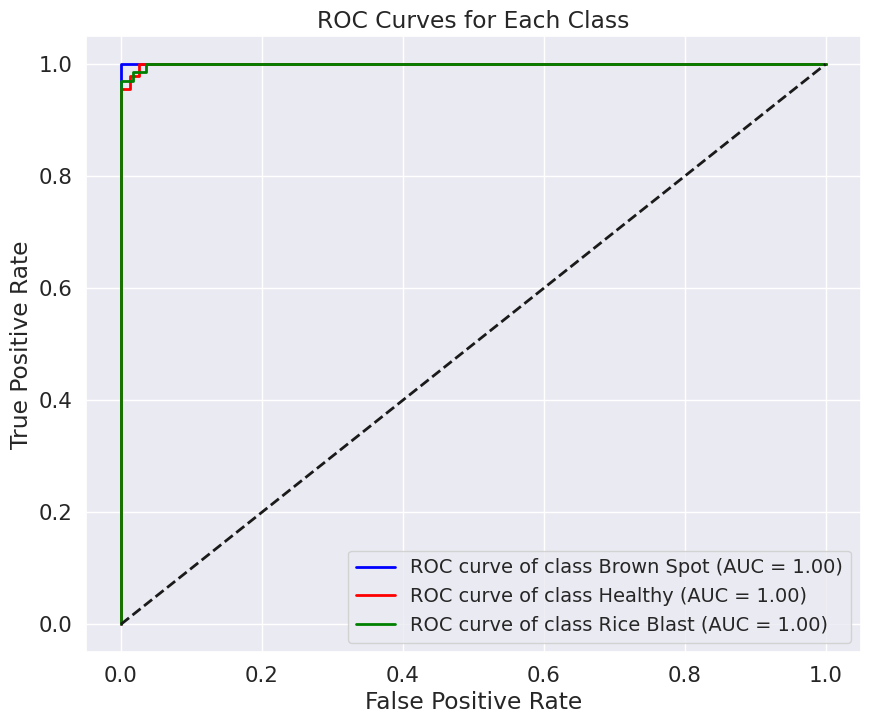

In [ ]:
# Plotting ROC Curves for each class

class_names = label_encoder.classes_
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(tf.keras.utils.to_categorical(true_labels_encoded, n_classes)[:, i], class_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right", fontsize="small")
plt.show()

In [ ]:
# Classification report
report = classification_report(true_labels_encoded, class_predictions, target_names=class_names)
print(report)

              precision    recall  f1-score   support

  Brown Spot       1.00      1.00      1.00        11
     Healthy       0.96      1.00      0.98        46
  Rice Blast       1.00      0.97      0.99        68

    accuracy                           0.98       125
   macro avg       0.99      0.99      0.99       125
weighted avg       0.98      0.98      0.98       125



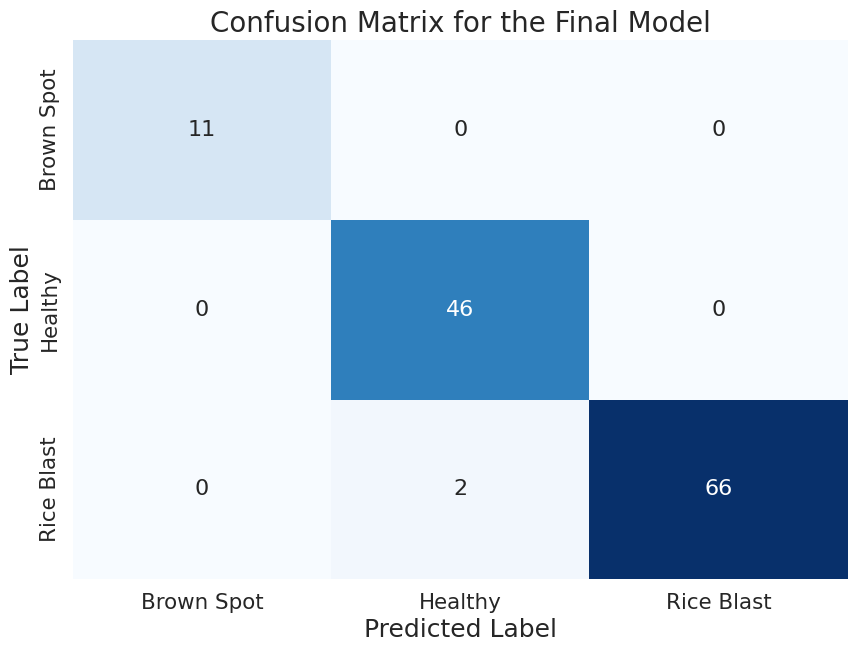

In [ ]:
# Plotting the confusion matrix using Seaborn

cm = confusion_matrix(true_labels_encoded, class_predictions)
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.title('Confusion Matrix for the Final Model', fontsize=20)
plt.show()